# Retail

### Problem Statement

- It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.  
- Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits.  
- Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).

### Project Task: Week 1
##### Data Cleaning:
1. Perform a preliminary data inspection and data cleaning.  
  a. Check for missing data and formulate an apt strategy to treat them.  
  b. Remove duplicate data records.  
  c. Perform descriptive analytics on the given data.  

##### Data Transformation:  
2. Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts.  
  a. Create month cohorts and analyze active customers for each cohort.  
  b. Analyze the retention rate of customers.

### Setup

Load the required libraries and configure some settings for plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import squarify
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
%matplotlib inline
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Importing data

In [3]:
data = pd.read_excel('Online Retail.xlsx',
                     dtype = {'CustomerID': str,
                             'InvoiceNo': str},
                    parse_dates = ['InvoiceDate']
                    )
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# As for the analysis, we need to have customer IDs, we drop all the rows without them.
data.dropna(subset = ['CustomerID'], inplace = True)

In [7]:
# Check the duplicates
data.duplicated().sum()

5225

In [8]:
data.drop_duplicates(inplace = True)

### Exploratory Data Analysis

In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0


In [10]:
(data['Quantity'] < 0).sum()

8872

In [11]:
data = data[data['Quantity'] > 0]

We can see that there are orders with negative quantity — most likely returns. In total, there are around 9 thousand purchases with a negative quantity. We remove them from the dataset.

In [12]:
# Calculate an aggregate metric indicating how many orders were placed by each customer and plot the distribution
num_orders = data.groupby('CustomerID')['InvoiceNo'].nunique()

In [13]:
multi_orders_pct = np.sum(num_orders > 1) / data['CustomerID'].nunique()
print('Customers ordered more than once are {:.2f}%.'.format(multi_orders_pct * 100))

Customers ordered more than once are 65.57%.


C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of number of orders per customer'),
 Text(0.5, 0, 'Number of orders'),
 Text(0, 0.5, 'Number of customers')]

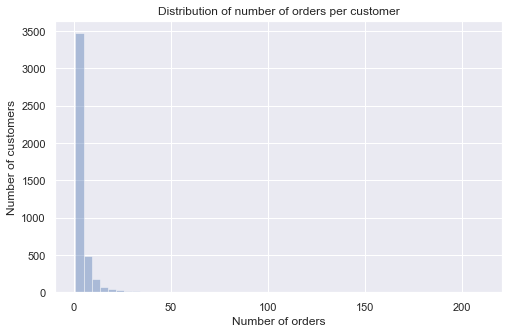

In [14]:
plt.figure(figsize = (8, 5))
fig = sns.distplot(num_orders, color = 'b', kde = False)
fig.set(title = 'Distribution of number of orders per customer',
        xlabel = 'Number of orders',
        ylabel = 'Number of customers')

### Cohort Analysis

In [15]:
# Keep only relevant columns
data_ca = data[['InvoiceNo', 'InvoiceDate', 'CustomerID']]

In [16]:
# Since we're doing monthly cohorts, we'll be looking at the total monthly behavior of our customers
data_ca['order_month'] = data_ca['InvoiceDate'].dt.to_period('M')
#data_ca['order_month'] = pd.DatetimeIndex(data_ca['InvoiceDate']).month

C:\Users\bnmwe\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# Determine the customer's cohort group (based on their first order)
data_ca['cohort'] = data_ca.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
data_ca.sample(10)

C:\Users\bnmwe\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,InvoiceNo,InvoiceDate,CustomerID,order_month,cohort
171622,551437,2011-04-28 15:13:00,13725,2011-04,2011-02
360094,568211,2011-09-25 15:59:00,13429,2011-09,2011-09
97962,544662,2011-02-22 14:10:00,12845,2011-02,2011-02
392724,570715,2011-10-12 10:23:00,18287,2011-10,2011-05
143972,548714,2011-04-03 15:07:00,17337,2011-04,2011-02
78276,542862,2011-02-01 11:51:00,14606,2011-02,2010-12
398047,571217,2011-10-14 13:24:00,17451,2011-10,2011-08
89799,543975,2011-02-14 15:23:00,17231,2011-02,2010-12
195931,553765,2011-05-19 10:43:00,17245,2011-05,2011-05
204017,554628,2011-05-25 11:26:00,15039,2011-05,2010-12


In [18]:
data_ca = data_ca.groupby(['cohort', 'order_month']).agg(num_customers=('CustomerID' , 'nunique')).reset_index(drop=False)
data_ca['period_number'] = (data_ca.order_month - data_ca.cohort).apply(attrgetter('n'))

In [19]:
data_ca['CohortPeriod'] = np.arange(len(data_ca)) + 1

In [20]:
data_ca.head(20)

,cohort,order_month,num_customers,period_number,CohortPeriod
0,2010-12,2010-12,885,0,1
1,2010-12,2011-01,324,1,2
2,2010-12,2011-02,286,2,3
3,2010-12,2011-03,340,3,4
4,2010-12,2011-04,321,4,5
5,2010-12,2011-05,352,5,6
6,2010-12,2011-06,321,6,7
7,2010-12,2011-07,309,7,8
8,2010-12,2011-08,313,8,9
9,2010-12,2011-09,350,9,10


In [21]:
cohort_pivot = data_ca.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'num_customers')

In [22]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

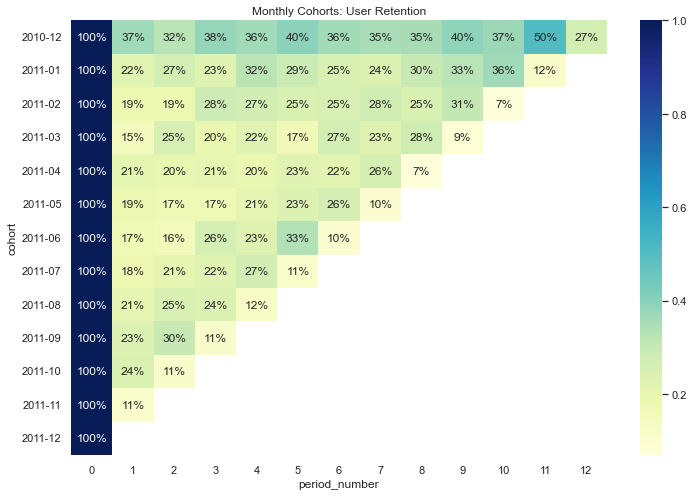

In [24]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Monthly Cohorts: User Retention')
sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), cmap="YlGnBu", annot=True, fmt='.0%');


### Project Task: Week 2
##### Data Modeling :

1. Build a RFM (Recency Frequency Monetary) model. Recency means the number of days since a customer made the last purchase. Frequency is the number of purchase in a given period. It could be 3 months, 6 months or 1 year. Monetary is the total amount of money a customer spent in that given period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP.  


2. Calculate RFM metrics.  


3. Build RFM Segments. Give recency, frequency, and monetary scores individually by dividing them into quartiles.  


    b1. Combine three ratings to get a RFM segment (as strings).  
    b2. Get the RFM score by adding up the three ratings.  
    b3. Analyze the RFM segments by summarizing them and comment on the findings.  

Note: Rate “recency" for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent.
Note: Rate “frequency" and “monetary" higher, because the company wants the customer to visit more often and spend more money.

## Recency, Frequency, Monetary Model

To calculate recency, we will be taking one day after the last invoice date of our data set as the snapshot date ‘2011–12–10 12:50:00’. The date difference will give us how recent the last transaction was made.

In [25]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [26]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [27]:
# Create TotalSum column for dataset
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

# Create snapshot date
snapshot_date = data['InvoiceDate'].max() + datetime.timedelta(days = 1)
print(snapshot_date)

# Grouping by CustomerID
data_rfm = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                           'InvoiceNo': 'count',
                                           'TotalSum': 'sum'})

# Rename the columns 
data_rfm.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'Monetary'}, inplace=True)

2011-12-10 12:50:00


In [28]:
data_rfm.head()
print('{:,} rows; {:,} columns'
      .format(data_rfm.shape[0], data_rfm.shape[1]))

rfm = data_rfm.copy()

4,339 rows; 3 columns


C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

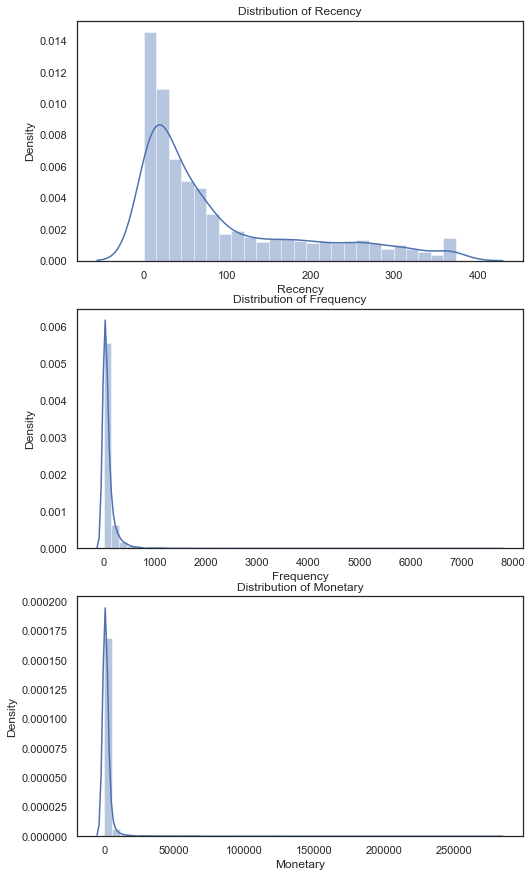

<Figure size 432x288 with 0 Axes>

In [29]:
# Examine the distribution of our Recency, Frequency, and Monetary
fig, axes = plt.subplots(3, 1, figsize = (8, 15))

sns.distplot(rfm['Recency'], ax = axes[0])
axes[0].set_title('Distribution of Recency')
sns.distplot(rfm['Frequency'], ax = axes[1])
axes[1].set_title('Distribution of Frequency')
sns.distplot(rfm['Monetary'], ax = axes[2])
axes[2].set_title('Distribution of Monetary')
plt.show()
plt.tight_layout()

#### This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles.

In [30]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm['Recency'], q = 4, labels = r_labels)
f_groups = pd.qcut(rfm['Frequency'], q = 4, labels = f_labels)
m_groups = pd.qcut(rfm['Monetary'], q = 4, labels = m_labels)
# Create new columns R and F 
rfm = rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,326,1,77183.60,1,1,4
12347,2,182,4310.00,4,4,4
12348,75,31,1797.24,2,2,4
12349,19,73,1757.55,3,3,4
12350,310,17,334.40,1,1,2


In [31]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,4,1.01.04.0
12347,2,182,4310.00,4,4,4,4.04.04.0
12348,75,31,1797.24,2,2,4,2.02.04.0
12349,19,73,1757.55,3,3,4,3.03.04.0
12350,310,17,334.40,1,1,2,1.01.02.0


In [32]:
# Count number of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

61


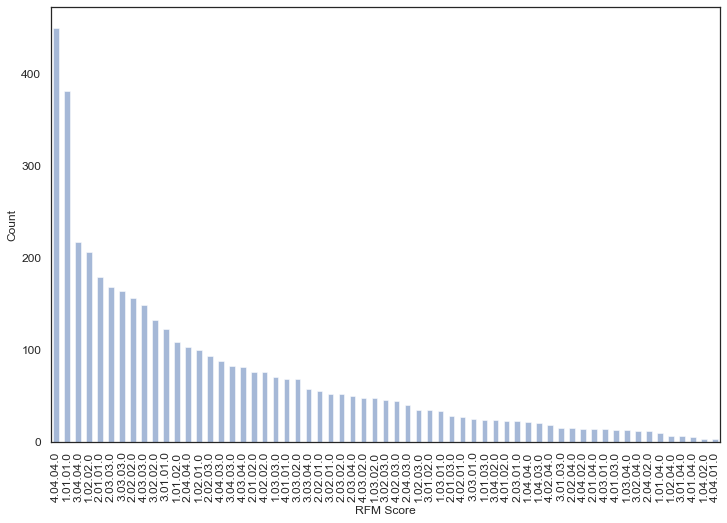

In [33]:
ax = rfm['RFM_Segment'].value_counts().plot(kind='bar', figsize=(12, 8), fontsize=12, color = 'b', alpha = 0.5)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

#### We can see that our largest segment is made up of our most valuable customers. However, our next largest segment is made up of our least valuable customers.  From the output, we have our concatenated segments ready to be used for our segmentation, but Having 62 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments. One of the most straightforward methods is to sum our scores to a single number and define RFM levels for each score range.

In [34]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis = 1)
print(rfm['RFM_Score'].head())

CustomerID
12346     6
12347    12
12348     8
12349    10
12350     4
Name: RFM_Score, dtype: int64


In [35]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Cannot Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Requires Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,4,1.01.04.0,6,Potential
12347,2,182,4310.00,4,4,4,4.04.04.0,12,Cannot Loose Them
12348,75,31,1797.24,2,2,4,2.02.04.0,8,Champions
12349,19,73,1757.55,3,3,4,3.03.04.0,10,Cannot Loose Them
12350,310,17,334.40,1,1,2,1.01.02.0,4,Needs Attention


#### Then we can finally group our customers by their RFM level

In [36]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({'Recency': 'mean',
                                              'Frequency': 'mean',
                                              'Monetary': ['mean', 'count']}).round(2)
# Print the aggregated dataset
print(rfm_level_agg)

                    Recency Frequency Monetary      
                       mean      mean     mean count
RFM_Level                                           
Cannot Loose Them     26.45    189.38  4394.67  1677
Champions             64.06     56.03   987.32   454
Loyal                 79.43     37.94   757.14   464
Needs Attention      177.21     13.60   239.99   388
Potential             95.91     27.84   820.14   457
Promising            152.93     21.20   366.60   518
Requires Activation  260.73      8.20   157.42   381


#### We can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The store must be doing something right to be maintaining their loyalty!

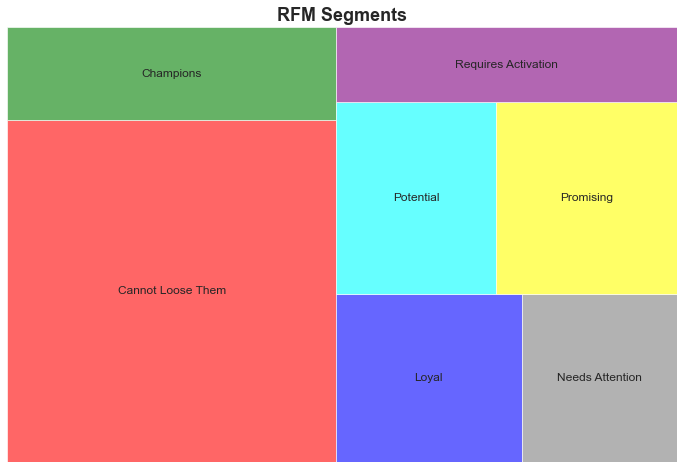

In [37]:
# Build treemaps using Squarify and matplotlib
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
# Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Cannot Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Requires Activation'],
              color = ['red','green','blue', 'grey', 'cyan', 'yellow', 'purple'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

### Project Task: Week 3
#### Data Modeling :

1. Create clusters using k-means clustering algorithm.

  a. Prepare the data for the algorithm. If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardize the data.  
  b. Decide the optimum number of clusters to be formed.  
  c. Analyze these clusters and comment on the results.

### RFM Segmentation Using K-Means Clustering
From above analysis, we can see there is a general skewnesss of R, F and M to the right. To address this, we will apply log transformation to our data.

In [38]:
data_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [39]:
# Apply log transformation
data_rfm_log = np.log(data_rfm + 1)
#data_rfm['recency_log'] = np.log(data_rfm['Recency'])
#data_rfm['frequency_log'] = np.log(data_rfm['Frequency'])
#data_rfm['monetary_log'] = np.log(data_rfm['Monetary'])

C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\bnmwe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

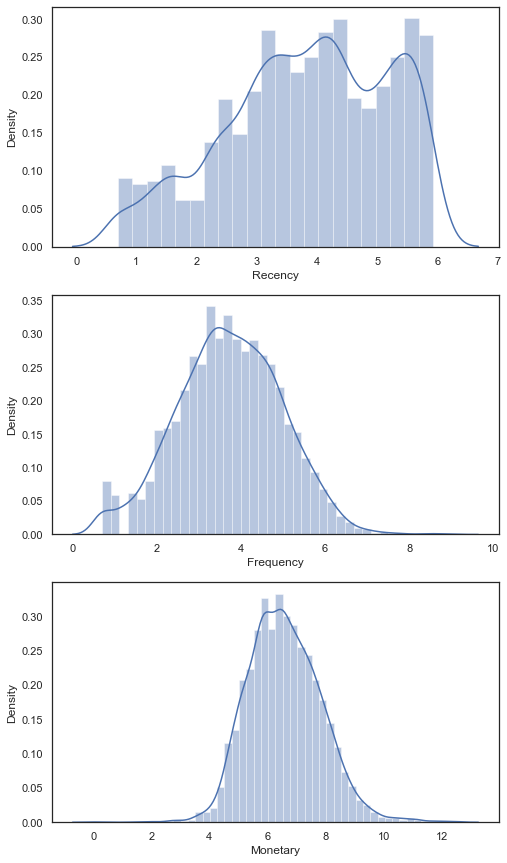

In [40]:
# Plot RFM distributions
plt.figure(figsize=(8,15))
plt.subplot(3, 1, 1)
sns.distplot(data_rfm_log['Recency'])
plt.subplot(3, 1, 2)
sns.distplot(data_rfm_log['Frequency'])
plt.subplot(3, 1, 3)
sns.distplot(data_rfm_log['Monetary'])
plt.show()

In [41]:
data_rfm_log.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,3.830475,3.728500,6.587044
std,1.340215,1.245858,1.262262
min,0.693147,0.693147,0.000000
25%,2.944439,2.890372,5.728329
50%,3.951244,3.737670,6.506621
75%,4.962845,4.595120,7.415365
max,5.926926,8.945984,12.543284


In [42]:
# Standardrizing the data
scaler = StandardScaler()
scaler.fit(data_rfm_log)

data_rfm_scaled = scaler.transform(data_rfm_log)

Text(0, 0.5, 'WCSS')

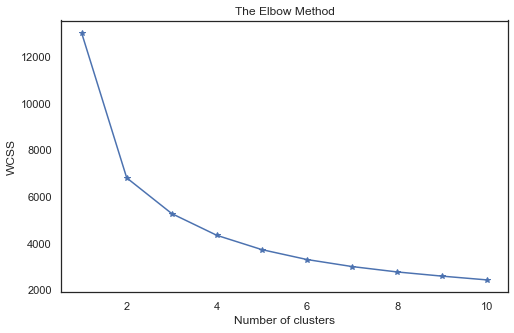

In [43]:
# Fit KMeans and calculate SSE for each *k*
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 2)
    kmeans.fit(data_rfm_scaled)
    wcss.append(kmeans.inertia_)

fig, axes = plt.subplots(figsize=(8, 5))    
plt.plot(range(1, 11), wcss, '-*')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


#### Ideally, we want to choose the point on the elbow chart where the WCSS stops decreasing at an increasing rate, i.e. the point where the change gradient of between the number of clusters becomes constant. For our model we will choose k=4.

In [44]:
# Choose k=4 and fit data set to k-means model
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(data_rfm_scaled)
# Assign k-means labels to cluster labels
cluster_labels = kmeans.labels_
# Assign cluster labels to original pre-transformed data set
data_rfm_k4 = data_rfm.assign(Cluster = cluster_labels)
# Group data set by k-means cluster
data_rfm_k4.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'}).round(0)


,Recency,Frequency,Monetary
Cluster,,,
0,186.0,15.0,298.0
1,20.0,38.0,604.0
2,95.0,79.0,1520.0
3,13.0,280.0,7053.0


In [45]:
data_rfm_scaled = pd.DataFrame(data_rfm_scaled,
index=data_rfm.index,
columns=data_rfm.columns)
data_rfm_scaled['Cluster'] = data_rfm_k4['Cluster']

<AxesSubplot:title={'center':'Snake plot of Cluster'}, xlabel='Attribute', ylabel='Value'>

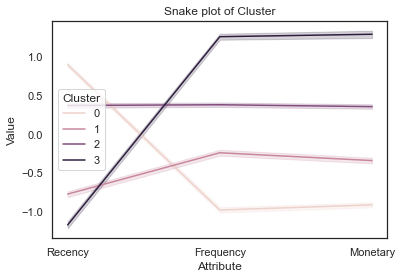

In [46]:
# Visualize a snake plot
data_melt = pd.melt(data_rfm_scaled.reset_index(),
id_vars=['CustomerID', 'Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'],
var_name='Attribute',
value_name='Value')
plt.title('Snake plot of Cluster')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

In [47]:
cluster_avg = data_rfm_k4.groupby(['Cluster']).mean()
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1

In [48]:
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,1.02,-0.83,-0.85
1,-0.78,-0.58,-0.71
2,0.03,-0.12,-0.26
3,-0.86,2.10,2.44


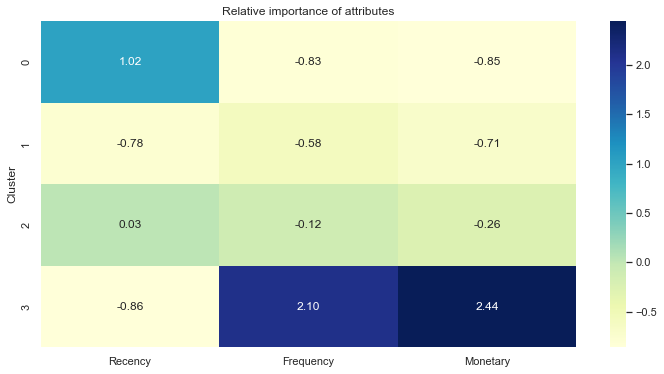

In [49]:
# Relative importance heatmap
plt.figure(figsize=(12, 6))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='YlGnBu')
plt.show()

### We can see each cluster of customers places a different emphasis on our features (R, F and M).

- Cluster 0 performs poorly, and has the lowest frequency and monetary, hasn't shopped with us for half a year - we will need to design campaigns to activate them again.
- Cluster 1 shopped with us recently but have not spend as much or as frequently as we would like them to — perhaps some personalization of products targeted at them can help to maximize their lifetime-value.
- Cluster 2 has spent quite a fair amount with us but has not shopped with us in the 3–4 months — We will need to take some actions before we lose them!
- Cluster 3 has the highest Montary mean and lowest Recency mean and the highest frequency mean — This is our ideal core customer segment.

### Project Task: Week 4
#### Data Reporting:​​​​​​​

1. Create a dashboard in tableau by choosing appropriate chart types and metrics useful for the business. The dashboard must entail the following:

  a. Country-wise analysis to demonstrate average spend. Use a bar chart to show the monthly figures 
  b. Bar graph of top 15 products which are mostly ordered by the users to show the number of products sold  
  c. Bar graph to show the count of orders vs. hours throughout the day  
  d. Plot the distribution of RFM values using histogram and frequency charts  
  e. Plot error (cost) vs. number of clusters selected  
  f. Visualize to compare the RFM values of the clusters using heatmap

### Here is my tableau report link.

https://public.tableau.com/app/profile/baomei.wen/viz/RFMAnalysisinOnlineRetail/Dashboard1